In [1]:
# import Pkg; Pkg.add("LibSerialPort")
# import Pkg; Pkg.add("TickTock")

In [2]:
using LibSerialPort
using TickTock
using Plots


list_ports()
ports = get_port_list()

┌ Warning: backend `GR` is not installed.
└ @ Plots ~/.julia/packages/Plots/QZRtR/src/backends.jl:43


[ Info: GR


/dev/cu.wlan-debug
	Description:	wlan-debug
	Transport type:	SP_TRANSPORT_NATIVE
/dev/cu.Bluetooth-Incoming-Port
	Description:	Bluetooth-Incoming-Port
	Transport type:	SP_TRANSPORT_NATIVE
/dev/cu.usbserial-56230387121
	Description:	USB Single Serial
	Transport type:	SP_TRANSPORT_NATIVE


3-element Vector{String}:
 "/dev/cu.wlan-debug"
 "/dev/cu.Bluetooth-Incoming-Port"
 "/dev/cu.usbserial-56230387121"

In [3]:
ports

3-element Vector{String}:
 "/dev/cu.wlan-debug"
 "/dev/cu.Bluetooth-Incoming-Port"
 "/dev/cu.usbserial-56230387121"

In [12]:
using LibSerialPort

sp = LibSerialPort.open("/dev/cu.usbserial-56230387121", 115200)
set_flow_control(sp)
sp_flush(sp, SP_BUF_BOTH)
println(readline(sp))
println(readline(sp))
write(sp, "<0, 0>") # first is elbow, second is linear rail

close(sp)

4,0.000,
0.844,0.000,0.322,0.005,-1.924,0.000,


In [ ]:
# set the acceleration to 100 for 1 second with dt of 1ms

dt = 0.005
tf = 2
t_vec = 0:dt:tf
N = length(t_vec)
linearPositions = zeros(N)
elbowPositions = zeros(N)
linearVelocities = zeros(N)
elbowVelocities = zeros(N)
shoulderPositions = zeros(N)
shoulderVelocities = zeros(N)
elbowRequested = zeros(N)
linearRequested = zeros(N)

println(N)

sp = LibSerialPort.open("/dev/cu.usbserial-56230387121", 38400)
set_flow_control(sp)
sp_flush(sp, SP_BUF_BOTH)

tick()
for i in 1:N

    encoded = false
    while(!encoded)
        try 
            encoders = readline(sp)
            encoders = readline(sp)
            encodersSplit = split(encoders, ",")
            

            linearPositions[i] = parse(Float64, encodersSplit[1])
            linearVelocities[i] = parse(Float64, encodersSplit[2])
            shoulderPositions[i] = parse(Float64, encodersSplit[3])
            shoulderVelocities[i] = parse(Float64, encodersSplit[4])
            elbowPositions[i] = parse(Float64, encodersSplit[5])
            elbowVelocities[i] = parse(Float64, encodersSplit[6])
            # elbowRequested[i] = parse(Float64, encodersSplit[7])
            # linearRequested[i] = parse(Float64, encodersSplit[8])
            encoded = true
        catch
            println("error", i)
        end
    end


    if (i < N/2)
        # write(sp, "<0, -4000>") # first is elbow, second is linear rail
        write(sp, "<0, 0>") # first is elbow, second is linear rail
    else
        write(sp, "<0, 0>") # first is elbow, second is linear rail
    end

    sleep(dt) # micro seconds
end
tock()

write(sp, "<0, 0>") # first is elbow, second is linear rail
close(sp)


In [164]:
ENCODER_LINEAR_ANGULAR_RATIO_M = 0.00602;
ENCODER_LINEAR_ANGULAR_RATIO_CM = 0.602;
ENCODER_ELBOW_ANGULAR_RATIO= 0.2;
ENCODER_SHOULDER_ANGULAR_RATIO = 1.0;

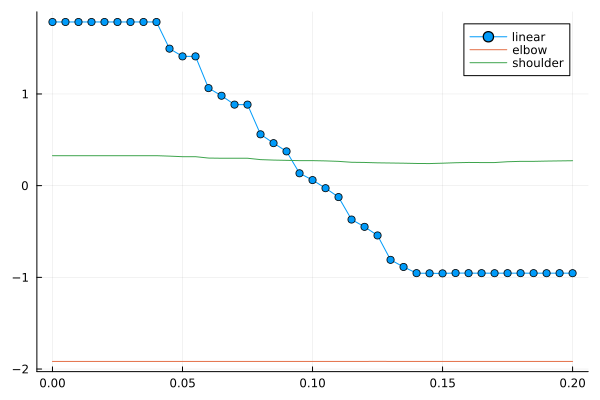

In [165]:
# plot the various positions over time
plot(t_vec, linearPositions * ENCODER_LINEAR_ANGULAR_RATIO_CM, label="linear", marker=:dot)
plot!(t_vec, elbowPositions, label="elbow")
plot!(t_vec, shoulderPositions, label="shoulder")

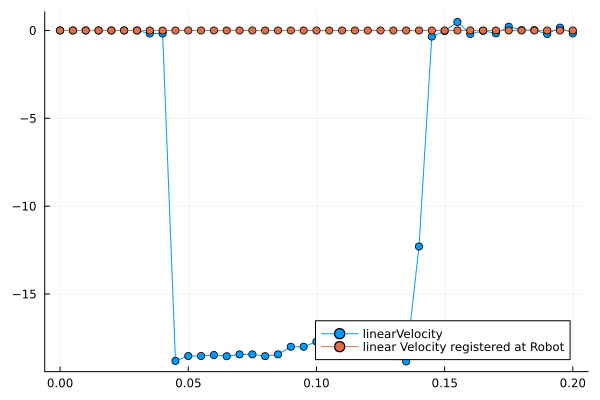

In [166]:
# plot the various velocities over time, each point should be a dot
plot(t_vec, linearVelocities * ENCODER_LINEAR_ANGULAR_RATIO_CM, label="linearVelocity", marker=:dot)
# plot!(t_vec, elbowVelocities, label="elbow", marker=:dot)
# plot!(t_vec, shoulderVelocities, label="shoulder", marker=:dot)
# plot!(t_vec, elbowRequested, label="elbow requested", marker=:dot)
plot!(t_vec, linearRequested / -1000, label="linear Velocity registered at Robot", marker=:dot)

Problems: 
* Inconsistent sleep time

In [76]:
# import Pkg; Pkg.add("JLD2")
using JLD2
traj = jldopen("./cartpole_swingup.jld2", "r")
traj = jldopen("./cartpole_swingup_100ms_10s.jld2", "r")
X = traj["X"]

101-element Vector{Vector{Float64}}:
 [-3.0984724878352865e-30, -3.5129308251160064e-30, -1.5627575792769598e-30, 1.2547750383410388e-30]
 [-0.0039375044093136686, 0.009638688608895135, -0.07717096570291737, 0.18488484041709527]
 [-0.011618957926831715, 0.026127639073725995, -0.07376453124904027, 0.1314232005136461]
 [-0.019516896462457158, 0.036872623229787745, -0.08244334610340306, 0.07471038201611803]
 [-0.028855482691678095, 0.0422890292848597, -0.10344656649520784, 0.029200815711398216]
 [-0.04063843432740988, 0.04353135442904933, -0.13201018599303266, -0.005367521243017284]
 [-0.05535031824220925, 0.041486332749711814, -0.16256062569428595, -0.03386456965386749]
 [-0.07191765243820875, 0.03401949680273698, -0.17000000993863357, -0.10938862036395777]
 [-0.08879639354748478, 0.019146497286937087, -0.17000000996444942, -0.17593346006017047]
 [-0.10563631067455195, -0.00041898142800650515, -0.1700000099582367, -0.19937572840810625]
 ⋮
 [-0.0833386532619973, 1.5810651812993943, -0.170

In [77]:
# extract the 3rd element of the vector of vectors and save that as a velocity vector
velocity = [x[3] for x in X]
println(maximum(velocity))
println(minimum(velocity))

position = [x[1] for x in X]
println(maximum(position))
println(minimum(position))

0.1700000099999786
-0.17000000999996973


0.0
-0.1712805315020025


In [13]:
speed_mult = 22222
dt = 0.1
tf = 10
t_vec = 0:dt:tf
N = length(t_vec)
linearPositions = zeros(N)
elbowPositions = zeros(N)
linearVelocities = zeros(N)
elbowVelocities = zeros(N)
shoulderPositions = zeros(N)
shoulderVelocities = zeros(N)
elbowRequested = zeros(N)
linearRequested = zeros(N)

dt = 0.096

println(N)

sp = LibSerialPort.open("/dev/cu.usbserial-56230387121", 115200)
set_flow_control(sp)
sp_flush(sp, SP_BUF_BOTH)

tick()
for i in 1:N
    encoders = readline(sp)
    encodersSplit = split(encoders, ",")

    linearPositions[i] = parse(Float64, encodersSplit[1])
    linearVelocities[i] = parse(Float64, encodersSplit[2])
    shoulderPositions[i] = parse(Float64, encodersSplit[3])
    shoulderVelocities[i] = parse(Float64, encodersSplit[4])
    elbowPositions[i] = parse(Float64, encodersSplit[5])
    elbowVelocities[i] = parse(Float64, encodersSplit[6])
    # elbowRequested[i] = parse(Float64, encodersSplit[7])
    # linearRequested[i] = parse(Float64, encodersSplit[8])


    # convert to string with precision 2 decimal places
    velocity_string = string(round(velocity[i] * speed_mult, digits=1))
    command = "<0, " * velocity_string * ">"
    write(sp, command)
    write(sp, "<0, 0>")
    # println(command)

    sleep(dt) # micro seconds
end
tock()

write(sp, "<0, 0>") # first is elbow, second is linear rail
close(sp)


101


┌ Info:  started timer at: 2023-05-05T10:11:37.296
└ @ TickTock /Users/saraltayal/.julia/packages/TickTock/fGILW/src/TickTock.jl:54


OS error code 6: Device not configured


ErrorException: libserialport returned SP_ERR_FAIL - Host OS reported a failure.

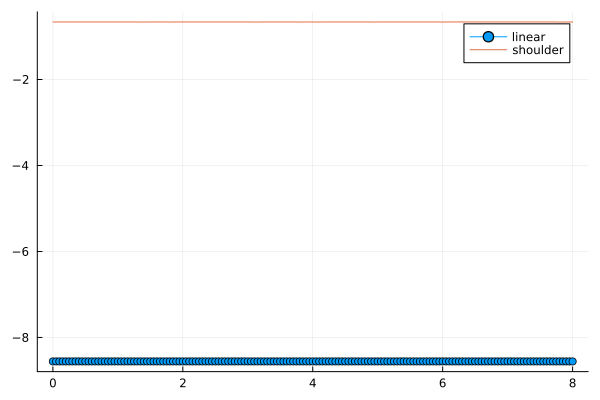

In [35]:
plot(t_vec, linearPositions * ENCODER_LINEAR_ANGULAR_RATIO_CM, label="linear", marker=:dot)
plot!(t_vec, shoulderPositions, label="shoulder")